In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
import requests
from tqdm import tqdm

from datetime import datetime


In [76]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [77]:
df = get_energy_data()

  0%|          | 0/256 [00:00<?, ?it/s]/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_89158/2942256061.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 256/256 [00:28<00:00,  9.12it/s]


In [78]:
df.head()

,Netzlast_Gesamt
date_time,
2018-12-24 00:00:00,42029.25
2018-12-24 01:00:00,39610.25
2018-12-24 02:00:00,39138.75
2018-12-24 03:00:00,39421.00
2018-12-24 04:00:00,40747.75


Rename column for convenience

In [79]:
df = df.rename(columns={"Netzlast_Gesamt": "gesamt"})

Rescale Netzlast so it fits requirements

In [80]:
df['gesamt'] = df['gesamt'] / 1000

Check dtypes and if columns contain and missing values

In [81]:
df.dtypes

gesamt    float64
dtype: object

In [82]:
df.isna().any()

gesamt    False
dtype: bool

Define weekday column

In [83]:
df["weekday"] = df.index.weekday #Monday=0, Sunday=6
#df["time"] = df.index.strftime("%H:%M")

Lead times are

In [84]:
horizons_def = [36, 40, 44, 60, 64, 68]#[24 + 12*i for i in range(5)]
horizons_def

[36, 40, 44, 60, 64, 68]

Adapt horzions so they actually fit

In [85]:
horizons = [h+1 for h in horizons_def]
horizons

[37, 41, 45, 61, 65, 69]

In [86]:
def get_date_from_horizon(last_ts, horizon):
    return last_ts + pd.DateOffset(hours=horizon)

In [87]:
LAST_IDX = -1
LAST_DATE = df.iloc[LAST_IDX].name
LAST_DATE

Timestamp('2023-11-15 22:00:00')

Get time and date that correspond to the lead times (starting at the last observation in our data which should be the respective thursday 0:00)  
*Attention*: if the last timestamp in the data is not thursday 0:00, you have to adjust your lead times accordingly

In [88]:
horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons]
horizon_date

[Timestamp('2023-11-17 11:00:00'),
 Timestamp('2023-11-17 15:00:00'),
 Timestamp('2023-11-17 19:00:00'),
 Timestamp('2023-11-18 11:00:00'),
 Timestamp('2023-11-18 15:00:00'),
 Timestamp('2023-11-18 19:00:00')]

quantile levels

In [89]:
tau = [.025, .25, .5, .75, .975]

In [90]:
#rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

In [91]:
#seasonal regression
# Create dummy variables for months and hours
df['month'] = df.index.month
df['hour'] = df.index.hour

# Get dummies for months and hours, excluding the first month and hour to avoid multicollinearity
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
hour_dummies = pd.get_dummies(df['hour'], prefix='hour', drop_first=True)

# Join the dummies with the original DataFrame
df = df.join(month_dummies).join(hour_dummies)


In [93]:
#baseline
last_t = 100

for i,d in enumerate(horizon_date):
    
    weekday = d.weekday()
    hour = d.hour
    
    df_tmp = df.iloc[:LAST_IDX]
    
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    pred_baseline[i,:] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)

In [94]:
pred_baseline

array([[53.63964375, 61.140375  , 64.2255    , 67.6838125 , 75.8170625 ],
       [50.97789375, 56.5423125 , 59.3595    , 62.9779375 , 70.57074375],
       [51.00661875, 54.904125  , 59.177125  , 63.7310625 , 71.5553875 ],
       [47.84225625, 51.7291875 , 54.42825   , 57.602875  , 64.05821875],
       [44.25519375, 47.6435    , 49.9185    , 53.1553125 , 60.6060375 ],
       [44.56158125, 47.8583125 , 51.4305    , 56.440125  , 63.6415375 ]])

Visually check if quantiles make sense

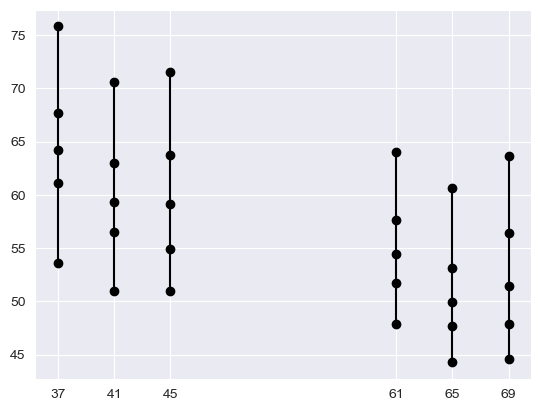

In [95]:
x = horizons
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

In [96]:
from datetime import datetime, date, timedelta
date_str = datetime.today().strftime('%Y%m%d')

In [97]:
date_str = date.today() #- timedelta(days=1)
date_str = date_str
date_str

datetime.date(2023, 11, 15)

In [98]:
df_sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons_def],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-15,energy,36 hour,53.639644,61.140375,64.225500,67.683813,75.817062
1,2023-11-15,energy,40 hour,50.977894,56.542313,59.359500,62.977937,70.570744
2,2023-11-15,energy,44 hour,51.006619,54.904125,59.177125,63.731063,71.555387
3,2023-11-15,energy,60 hour,47.842256,51.729188,54.428250,57.602875,64.058219
4,2023-11-15,energy,64 hour,44.255194,47.643500,49.918500,53.155312,60.606037
5,2023-11-15,energy,68 hour,44.561581,47.858313,51.430500,56.440125,63.641537


In [99]:
#need to change this

PATH = "../forecasts/"
date_str = date_str.strftime('%Y%m%d')

df_sub.to_csv(PATH+date_str+"_power_benchmark.csv", index=False)